In [1]:
import pandas as pd
import re
import spacy
from spacy.training import Example
import random

import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("videos.csv")
df.head(10)

,kind,videoId,publishedAt,channelId,title,description,tags,defaultLanguage,defaultAudioLanguage,contentDuration,viewCount,likeCount,favouriteCount,commentCount,topicCategories
0,youtube#video,85806,2024-01-15 00:59:29+00:00,33807,Unlocking the Benefits of Face Masks for Skin ...,NaN,NaN,en-US,en-US,PT9S,72.0,0.0,0.0,0.0,"['https://en.wikipedia.org/wiki/Health', 'http..."
1,youtube#video,30556,2023-10-27 19:32:16+00:00,46650,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,NaN,NaN,NaN,NaN,PT45S,257.0,7.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
2,youtube#video,51771,2024-09-28 01:23:22+00:00,14346,#trending #makeup #beautymakeup #yslbeauty #lu...,NaN,NaN,NaN,en-US,PT19S,164.0,4.0,0.0,2.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
3,youtube#video,45298,2023-07-13 15:19:28+00:00,50139,#shortvedio #balayage,NaN,NaN,NaN,NaN,PT14S,1207.0,20.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
4,youtube#video,43611,2023-04-29 18:47:37+00:00,8143,Full Face of Merit Beauty 🤎 featuring new Flus...,NaN,NaN,NaN,en,PT56S,8647.0,268.0,0.0,7.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
5,youtube#video,32398,2021-10-06 01:28:59+00:00,39642,body lotion fit tuber 👈|| girls body lotion 👆|...,NaN,"['body lotion fit tuber', 'fit tuber body loti...",NaN,NaN,PT17S,1366.0,15.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
6,youtube#video,90721,2021-02-02 13:04:11+00:00,25860,"Contour Tutorial / How to do Contouring, Blush...",Makeup and Hair by @jagrutililawala\n\n#bride ...,NaN,NaN,NaN,PT1M34S,41.0,2.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
7,youtube#video,77725,2022-11-14 20:58:31+00:00,27788,Best look comes from the best products! #best ...,www.sopoli10x.com \n\n Beauty &Fashion. We re...,NaN,NaN,NaN,PT30S,1859.0,42.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
8,youtube#video,81779,2025-05-08 10:52:09+00:00,7310,Finishing touches. #blackgirlmakeup#makeup#bla...,NaN,NaN,NaN,NaN,PT30S,606.0,4.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
9,youtube#video,43693,2025-06-19 01:45:26+00:00,47519,glowup tips ✨️ #jenny #kpop #skincare #skincar...,#JennyGlowUp\n#KpopGlowUp\n#BeforeVsAfter\n#Gl...,NaN,en,en,PT11S,8951.0,172.0,0.0,5.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...


### Data Cleaning

In [3]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)  # remove punctuation
    text = text.lower()
    return text

# Create clean_text directly from title, description, tags
df['clean_text'] = (
    df['title'].fillna('') + ' ' +
    df['description'].fillna('') + ' ' +
    df['tags'].fillna('')
).apply(clean_text)

# Preview
df['clean_text'].head(5)

,clean_text
0,unlocking the benefits of face masks for skin ...
1,get ready for the magic hydration glowingskin ...
2,trending makeup beautymakeup yslbeauty luxury ...
3,shortvedio balayage
4,full face of merit beauty featuring new flush...


In [4]:
nltk.download('punkt')        # for word_tokenize
nltk.download('stopwords')    # for stopwords
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # tokenize
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return " ".join(tokens)

# Combine columns and clean
df['clean_text'] = (
    df['title'].fillna('') + ' ' +
    df['description'].fillna('') + ' ' +
    df['tags'].fillna('')
).apply(preprocess_text)

df['clean_text'].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,clean_text
0,unlocking benefits face masks skin health
1,get ready hydration glowingskin nomakeuplook s...
2,trending makeup beautymakeup yslbeauty luxury ...
3,shortvedio balayage
4,full face merit beauty featuring new flush bal...


### Spacy

In [36]:
TRAIN_DATA = [
    ("I love foundation and lipstick",
     {"entities": [(8, 17, "PRODUCT"), (23, 30, "PRODUCT")]}),

    ("lipstick and foundation are my faves",
     {"entities": [(0, 8, "PRODUCT"), (14, 23, "PRODUCT")]}),

    ("blush is amazing today",
     {"entities": [(0, 5, "PRODUCT")]}),

    ("perfume smells nice",
     {"entities": [(0, 7, "PRODUCT")]}),

    ("I just bought mascara & lipstick",
     {"entities": [(15, 21, "PRODUCT"), (25, 32, "PRODUCT")]}),

    ("highlighter, contour palette!",
     {"entities": [(0, 11, "PRODUCT"), (14, 29, "PRODUCT")]}),

    ("eyeshadow, blush, eyeliner",
     {"entities": [(0, 9, "PRODUCT"), (12, 16, "PRODUCT"), (19, 26, "PRODUCT")]}),

    ("lipstick lasts, mascara too",
     {"entities": [(0, 8, "PRODUCT"), (18, 24, "PRODUCT")]}),

    ("skincare moisturizer & blush",
     {"entities": [(0, 8, "PRODUCT"), (24, 28, "PRODUCT")]}),

    ("foundation is amazing",
     {"entities": [(0, 10, "PRODUCT")]}),

    ("eyeshadow palette and lip gloss",
     {"entities": [(0, 17, "PRODUCT"), (23, 31, "PRODUCT")]}),

    ("lip balm; concealer",
     {"entities": [(0, 9, "PRODUCT"), (12, 20, "PRODUCT")]}),

    ("eyebrow pencil, blush compact",
     {"entities": [(0, 14, "PRODUCT"), (17, 21, "PRODUCT")]}),

    ("mascara eyeliner",
     {"entities": [(0, 7, "PRODUCT"), (9, 16, "PRODUCT")]}),

    ("lip gloss, bronzer",
     {"entities": [(0, 9, "PRODUCT"), (12, 18, "PRODUCT")]}),

    ("foundation + lipstick",
     {"entities": [(0, 10, "PRODUCT"), (14, 21, "PRODUCT")]}),

    ("fragrance, lip balm, perfume",
     {"entities": [(0, 9, "PRODUCT"), (12, 19, "PRODUCT"), (22, 28, "PRODUCT")]}),

    ("blush, eyeliner, mascara",
     {"entities": [(0, 5, "PRODUCT"), (8, 15, "PRODUCT"), (18, 24, "PRODUCT")]}),

    ("bb cream, compact shell, brow pomade",
     {"entities": [(0, 8, "PRODUCT"), (11, 23, "PRODUCT"), (26, 36, "PRODUCT")]}),

    ("hip oil, bb cream, concealer",
     {"entities": [(0, 7, "PRODUCT"), (10, 17, "PRODUCT"), (20, 29, "PRODUCT")]}),

    ("hypercurl mascara, cheeky glow blush",
     {"entities": [(11, 17, "PRODUCT"), (32, 36, "PRODUCT")]}),

    ("megaglow highlighter, colorstay lip color",
     {"entities": [(10, 21, "PRODUCT")]}),

    ("benefits of face masks for skin health",
     {"entities": [(13, 22, "PRODUCT")]}),

    ("body serum",
     {"entities": [(0, 11, "PRODUCT")]}),

    ("deep conditioning like dancing shower shorts, deepconditioning",
     {"entities": [(0, 21, "PRODUCT"), (43, 63, "PRODUCT")]}),

    ("natural looking bronzer, orange bronzer",
     {"entities": [(17, 23, "PRODUCT"), (33, 39, "PRODUCT")]}),

    ("After trying the new highlighter and contour palette, my makeup looks amazing",
     {"entities": [(22, 32, "PRODUCT"), (38, 44, "PRODUCT")]}),

    ("Eyebrow pencil, blush compact, and lip gloss are all essentials in my kit",
     {"entities": [(0, 16, "PRODUCT"), (19, 23, "PRODUCT"), (38, 46, "PRODUCT")]}),

    ("Finally got the bb cream, compact shell, brow pomade, and body serum; my skin is loving it today",
     {"entities": [(17, 24, "PRODUCT"), (27, 39, "PRODUCT"), (42, 52, "PRODUCT"), (59, 68, "PRODUCT")]}),

    ("Trying out deep conditioning like dancing shower shorts and washday deepconditioning for the first time, feels so soft",
     {"entities": [(12, 28, "PRODUCT")]}),

    ("Natural looking bronzer, orange bronzer, hip oil, rose hip oil, and bb cream have been my go-to products this week",
     {"entities": [(17, 23, "PRODUCT"), (33, 39, "PRODUCT"), (42, 48, "PRODUCT"), (51, 62, "PRODUCT"), (69, 76, "PRODUCT")]}),

    ("Unlocking the benefits of face masks for skin health, body serum, and moisturizer has improved my daily routine",
     {"entities": [(27, 36, "PRODUCT"), (55, 64, "PRODUCT"), (70, 81, "PRODUCT")]}),

    ("Megaglow highlighter, colorstay lip color, cheeky glow blush, and hypercurl mascara have transformed my makeup looks",
     {"entities": [(10, 20, "PRODUCT"), (51, 60, "PRODUCT"), (77, 83, "PRODUCT")]}),
]


In [10]:
!pip install spacy-lookups-data
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 109.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [37]:
nlp = spacy.load("en_core_web_sm")
ner = nlp.get_pipe("ner")

ner.add_label("PRODUCT")

0

In [38]:
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.begin_training()

    for epoch in range(100):  # you can increase epochs for better results
        random.shuffle(TRAIN_DATA)
        losses = {}
        for text, annotations in TRAIN_DATA:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            nlp.update([example], drop=0.4, sgd=optimizer, losses=losses)
        print(f"Epoch {epoch+1}, Losses: {losses}")

nlp.to_disk("beauty_ner_model")

/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "highlighter, contour palette!" with entities "[(0, 11, 'PRODUCT'), (14, 29, 'PRODUCT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "megaglow highlighter, colorstay lip color" with entities "[(10, 21, 'PRODUCT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Megaglow highlighter, colorstay lip color, cheeky ..." with

Epoch 1, Losses: {'ner': np.float32(116.78346)}
Epoch 2, Losses: {'ner': np.float32(37.131744)}
Epoch 3, Losses: {'ner': np.float32(29.122593)}
Epoch 4, Losses: {'ner': np.float32(25.74756)}
Epoch 5, Losses: {'ner': np.float32(20.33705)}
Epoch 6, Losses: {'ner': np.float32(14.189878)}
Epoch 7, Losses: {'ner': np.float32(12.911959)}
Epoch 8, Losses: {'ner': np.float32(13.722365)}
Epoch 9, Losses: {'ner': np.float32(5.733176)}
Epoch 10, Losses: {'ner': np.float32(5.745734)}
Epoch 11, Losses: {'ner': np.float32(6.3273787)}
Epoch 12, Losses: {'ner': np.float32(4.5344477)}
Epoch 13, Losses: {'ner': np.float32(2.2059827)}
Epoch 14, Losses: {'ner': np.float32(4.4331484)}
Epoch 15, Losses: {'ner': np.float32(4.562335)}
Epoch 16, Losses: {'ner': np.float32(0.5789963)}
Epoch 17, Losses: {'ner': np.float32(2.5439177)}
Epoch 18, Losses: {'ner': np.float32(3.4429386)}
Epoch 19, Losses: {'ner': np.float32(4.2022357)}
Epoch 20, Losses: {'ner': np.float32(2.124999)}
Epoch 21, Losses: {'ner': np.float3

In [39]:
nlp2 = spacy.load("beauty_ner_model")

text = "washday deep conditioning like lipstick dancing shower shorts washday deepconditioning"
doc = nlp2(text)

for ent in doc.ents:
    print(ent.text, ent.label_)


In [46]:
nlp = spacy.load("beauty_ner_model")  # trained for products

def extract_products_only(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ == "PRODUCT"]

# Apply extraction only on first 5 rows
df_subset = df.iloc[5:10].copy()
df_subset['products'] = df_subset['clean_text'].apply(extract_products_only)

print(df_subset[['clean_text', 'products']])

                                          clean_text       products
5  body lotion fit tuber girls body lotion body l...  [moisturizer]
6  contour tutorial contouring blush highlight be...      [contour]
7  best look comes best products best makeup eyeb...             []
8  finishing touches blackgirlmakeup makeup black...             []
9  glowup tips jenny kpop skincare skincaregoals ...             []


In [ ]:
df.to_csv("youtube_beauty_products.csv", index=False)

Most mentioned products

/tmp/ipython-input-932095095.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='product', y='count', data=top_10, palette='viridis')


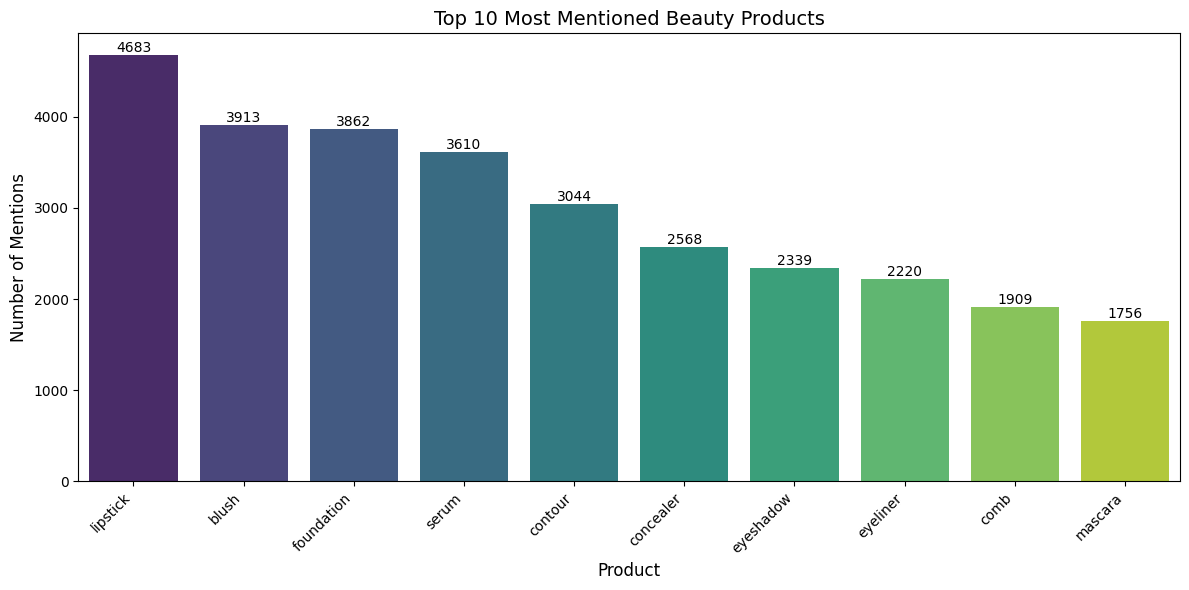

In [ ]:
all_products = [prod for sublist in df['products'].dropna() for prod in set(sublist)]  # remove duplicates per video
product_counts = Counter(all_products)

# Convert to DataFrame
product_counts_df = pd.DataFrame(product_counts.items(), columns=['product', 'count'])
product_counts_df = product_counts_df.sort_values(by='count', ascending=False)

# Top 10
top_10 = product_counts_df.head(10)

plt.figure(figsize=(12,6))
ax = sns.barplot(x='product', y='count', data=top_10, palette='viridis')

# Add counts on top of bars
for p in ax.patches:  # iterate over bars
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)

plt.title("Top 10 Most Mentioned Beauty Products", fontsize=14)
plt.xlabel("Product", fontsize=12)
plt.ylabel("Number of Mentions", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
top_10_json_path = "top_10_products.json"
top_10.to_json(top_10_json_path, orient="records", indent=2)

In [ ]:
import pandas as pd
import re

# Load CSV files
df_beauty = pd.read_csv("youtube_beauty_products.csv")  # beauty file
df_trend = pd.read_csv("trend_both_youtube.csv")        # trend file

# Normalize beauty products to flat lists
def normalize_products(products):
    if pd.isna(products):
        return []
    if isinstance(products, str):
        products = products.strip("[]")
        return [p.strip().strip("'\"") for p in products.split(",") if p.strip()]
    if isinstance(products, list):
        return products
    return []

df_beauty['products'] = df_beauty['products'].apply(normalize_products)

# Extract hashtags from text
def extract_hashtags(text):
    return re.findall(r"#(\w+)", str(text))

# Initialize a products column in trend file
df_trend['products'] = [[] for _ in range(len(df_trend))]

# Loop through each trend_id in trend file
for idx_trend, trend_row in df_trend.iterrows():
    trend_id = trend_row['trend_id'].lstrip("#")  # remove ## to match text hashtags

    # Loop through each beauty text row
    for _, beauty_row in df_beauty.iterrows():
        text_hashtags = extract_hashtags(beauty_row['text'])  # or 'clean_text' if you prefer
        if trend_id in text_hashtags:
            # Append products from beauty file, avoid duplicates
            existing_products = df_trend.at[idx_trend, 'products']
            for p in beauty_row['products']:
                if p not in existing_products:
                    existing_products.append(p)
            df_trend.at[idx_trend, 'products'] = existing_products

# Convert list of products to comma-separated string
df_trend['products'] = df_trend['products'].apply(lambda x: ', '.join(x))

# Save updated trend file
df_trend.to_csv("trend_both_youtube_updated.csv", index=False)
print("Updated trend file saved as trend_both_youtube_updated.csv")

In [49]:
df_trend = pd.read_csv("trend_both_youtube_updated.csv")
df_trend[['trend_id', 'products']].head(10)

,trend_id,products
0,##shorts,"moisturizer, body lotion, face powder, lipstic..."
1,##makeup,"bronzer, contour, lipstick, eyeliner, eyeshado..."
2,##yoga,"gua sha, comb, contour, lipstick, serum, acne ..."
3,##facelift,"gua sha, contour, blush, bronzer, highlighter,..."
4,##beauty,"foundation, lipstick, mascara, eyeshadow, blus..."
5,##skincare,"face powder, blush, lipstick, eyeshadow, bronz..."
6,##youtubeshorts,"face mask, foundation, blush, hair mask, perfu..."
7,##trending,"lipstick, eyeliner, eyeshadow, face mask, hair..."
8,##wrinkles,"gua sha, jade roller, comb, contour, face mask..."
9,##faceyoga,"gua sha, comb, contour, serum, acne treatment,..."


Loreal Products

In [48]:
!pip install fuzzywuzzy[speedup]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 40.8 MB/s eta 0:00:00


In [53]:
import pandas as pd
import json
from fuzzywuzzy import fuzz

# === Load files ===
csv_path = "trend_both_youtube_updated.csv"
brands_path = "loreal_brands.json"
products_path = "loreal_products.json"

df = pd.read_csv(csv_path)

with open(brands_path, "r", encoding="utf-8") as f:
    brands_data = json.load(f)

with open(products_path, "r", encoding="utf-8") as f:
    products_data = json.load(f)

# === Flatten brand data ===
brand_list = []
for category, items in brands_data.items():
    for b in items:
        brand_list.append({
            "brand": b["brand"],
            "description": b["description"],
            "category": category
        })

# === Flatten product data ===
product_list = [{"title": p["title"], "description": p["description"]} for p in products_data]

# === Matching functions ===
def get_best_product(products_str):
    """Return the single best-matching L'Oréal product"""
    if pd.isna(products_str):
        return None

    products = [p.strip().lower() for p in products_str.split(",")]
    best_score = 0
    best_product = None

    for prod in products:
        for item in product_list:
            score_title = fuzz.partial_ratio(prod, item["title"].lower())
            score_desc = fuzz.partial_ratio(prod, item["description"].lower())
            score = max(score_title, score_desc)
            if score > best_score:
                best_score = score
                best_product = item["title"]
    return best_product

def get_best_brands(trend_id, products_str, top_n=3):
    """Return 1–3 best-matching brands"""
    text = (str(trend_id) + " " + str(products_str)).lower()
    scored = []
    for b in brand_list:
        score_brand = fuzz.partial_ratio(b["brand"].lower(), text)
        score_desc = fuzz.partial_ratio(b["description"].lower(), text)
        score = max(score_brand, score_desc)
        if score > 50:  # relevance threshold
            scored.append((b["brand"], score))
    scored = sorted(scored, key=lambda x: x[1], reverse=True)
    best_brands = [s[0] for s in scored[:top_n]]
    return best_brands if best_brands else None

# === Apply to dataset ===
df["best_loreal_product"] = df["products"].apply(get_best_product)
df["best_brands"] = df.apply(lambda x: get_best_brands(x["trend_id"], x["products"]), axis=1)

# === Save result ===
output_path = "trend_with_loreal_mapping.csv"
df.to_csv(output_path, index=False)

print(f"✅ New CSV saved to {output_path}")

✅ New CSV saved to trend_with_loreal_mapping.csv


In [56]:
df[['trend_id', 'products', 'best_loreal_product', 'best_brands']].head(5)

,trend_id,products,best_loreal_product,best_brands
0,##shorts,"moisturizer, body lotion, face powder, lipstic...",Glycolic Bright\nGlycolic Bright 8% [Melasyl ™...,"[Garnier, Maybelline New York, NYX Professiona..."
1,##makeup,"bronzer, contour, lipstick, eyeliner, eyeshado...",Infallible Lip Makeup\nInfallible Matte Resist...,"[Garnier, Maybelline New York]"
2,##yoga,"gua sha, comb, contour, lipstick, serum, acne ...",Glycolic Bright\nAnti-Dark Spot Exfoliant Peel,"[Essie, Armani Beauty, Maison Margiela]"
3,##facelift,"gua sha, contour, blush, bronzer, highlighter,...",Infallible\nFull Wear More Than Concealer,"[CeraVe, Garnier]"
4,##beauty,"foundation, lipstick, mascara, eyeshadow, blus...",Infallible\n32H FreshWear Foundation,"[Carita, Valentino, Urban Decay]"


In [57]:
import pandas as pd
import json
from fuzzywuzzy import fuzz

# === Load files ===
csv_path = "trend_both_youtube_updated.csv"
brands_path = "loreal_brands.json"
products_path = "loreal_products.json"

df = pd.read_csv(csv_path)

with open(brands_path, "r", encoding="utf-8") as f:
    brands_data = json.load(f)

with open(products_path, "r", encoding="utf-8") as f:
    products_data = json.load(f)

# === Flatten brand data ===
brand_list = []
for category, items in brands_data.items():
    for b in items:
        brand_list.append({
            "brand": b["brand"],
            "description": b["description"],
            "category": category
        })

# === Flatten product data ===
product_list = [{"title": p["title"], "description": p["description"]} for p in products_data]

# === Matching functions ===
def get_best_product(products_str):
    """Return the best-matching L'Oréal product and its fuzz score"""
    if pd.isna(products_str):
        return None, 0

    products = [p.strip().lower() for p in products_str.split(",")]
    best_score = 0
    best_product = None

    for prod in products:
        for item in product_list:
            score_title = fuzz.partial_ratio(prod, item["title"].lower())
            score_desc = fuzz.partial_ratio(prod, item["description"].lower())
            score = max(score_title, score_desc)
            if score > best_score:
                best_score = score
                best_product = item["title"]

    return best_product, best_score


def get_best_brands(trend_id, products_str, top_n=3):
    """Return 1–3 best-matching brands with scores"""
    text = (str(trend_id) + " " + str(products_str)).lower()
    scored = []
    for b in brand_list:
        score_brand = fuzz.partial_ratio(b["brand"].lower(), text)
        score_desc = fuzz.partial_ratio(b["description"].lower(), text)
        score = max(score_brand, score_desc)
        if score > 50:  # threshold for relevance
            scored.append((b["brand"], score))
    scored = sorted(scored, key=lambda x: x[1], reverse=True)

    return scored[:top_n] if scored else None

# === Apply to dataset ===
# Products
df[["best_loreal_product", "product_score"]] = df["products"].apply(
    lambda x: pd.Series(get_best_product(x))
)

# Brands
df["brand_matches"] = df.apply(
    lambda x: get_best_brands(x["trend_id"], x["products"]), axis=1
)

df["best_brands"] = df["brand_matches"].apply(lambda x: [b for b, s in x] if x else None)
df["brand_scores"] = df["brand_matches"].apply(lambda x: [s for b, s in x] if x else None)

# === Save result ===
output_path = "trend_with_loreal_mapping_scored.csv"
df.to_csv(output_path, index=False)

print(f"✅ Scored results saved to {output_path}")

✅ Scored results saved to trend_with_loreal_mapping_scored.csv


In [59]:
df[["trend_id", "products", "best_loreal_product", "product_score", "best_brands", "brand_scores"]].head(5)

,trend_id,products,best_loreal_product,product_score,best_brands,brand_scores
0,##shorts,"moisturizer, body lotion, face powder, lipstic...",Glycolic Bright\nGlycolic Bright 8% [Melasyl ™...,100.0,"[Garnier, Maybelline New York, NYX Professiona...","[57, 53, 52]"
1,##makeup,"bronzer, contour, lipstick, eyeliner, eyeshado...",Infallible Lip Makeup\nInfallible Matte Resist...,100.0,"[Garnier, Maybelline New York]","[57, 53]"
2,##yoga,"gua sha, comb, contour, lipstick, serum, acne ...",Glycolic Bright\nAnti-Dark Spot Exfoliant Peel,100.0,"[Essie, Armani Beauty, Maison Margiela]","[60, 54, 53]"
3,##facelift,"gua sha, contour, blush, bronzer, highlighter,...",Infallible\nFull Wear More Than Concealer,100.0,"[CeraVe, Garnier]","[67, 57]"
4,##beauty,"foundation, lipstick, mascara, eyeshadow, blus...",Infallible\n32H FreshWear Foundation,100.0,"[Carita, Valentino, Urban Decay]","[67, 56, 55]"
